In [82]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle 
import numpy as np
import functools
import sys 
from tqdm import tqdm, trange
from classy import Class



from utils import *
from massfunction import *


import math
import torch
import gpytorch
from matplotlib import pyplot as pl

In [83]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.LinearMean(input_size=X_train.shape[1]), num_tasks=n_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
             gpytorch.kernels.SpectralMixtureKernel(num_mixtures=3, 
                                                    ard_num_dims=X_train.shape[1]),
            num_tasks=n_tasks, rank=1
        )
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    
class AemulusNu_HMF_Emulator:
    """
    Halo Mass Function Emulator,
    built from Aemulus-ν suite of simulations
    """
    
    def __init__(self):
        #TODO eventaully replace with local emuatlor
        self.MassFunctions = {}
#         with open("GP_emulator.pkl", "rb") as f:
        with open('/scratch/users/delon/aemulusnu_massfunction/GP_loBox0_1400.pkl', 'rb') as f:
            self.model, self.in_scaler, self.out_scaler, self.likelihood = pickle.load(f)
            self.model.eval()
            self.likelihood.eval()

    def predict(self, cosmology, z, m):
        """
        Parameters:
            - cosmology (dict): A dictioniary containing the cosmological parameters
                - 10^9 As: As * 10^9
                - ns: Spectral index
                - H0: Hubble parameter in [km/s/Mpc]
                - w0: Dark Energy Equation fo State
                - ombh2: Ω_b h^2
                - omch2: Ω_m h^2
                - nu_mass_ev: Neutrino mass sum in [eV]
                - sigma8: σ8 
            - z (float): Redshift to evaluate dn/dM at
            - m (float): Mass [M_solar / h] to evaluate dn/dM at
        Returns:
            - dn/dm (m,z): Halo Mass Function evaluated at mass 'm' 
                           during redshift 'z' for given cosmology
                           [h^4 Mpc^-3 Msolar^(-1)]
        """    
        
        a = redshiftToScale(z)
        
        cosmology['As'] = cosmology['10^9 As'] #account for poor naming convention in MassFunction
        
        key_ordering = ['10^9 As', 'ns', 'H0', 'w0', 'ombh2', 'omch2', 'nu_mass_ev', 'sigma8']
        curr_cosmo_values = [cosmology[curr_key] for curr_key in key_ordering]

        if(tuple(curr_cosmo_values) not in self.MassFunctions):
            self.MassFunctions[tuple(curr_cosmo_values)] = MassFunction(cosmology)
        
        mass_function = self.MassFunctions[tuple(curr_cosmo_values)]
        mass_function.compute_dlnsinvdM(a)
        
        
        sigma8 = mass_function.pkclass.sigma(8, z, h_units=True) #sigma8 at current redshift
        
        
        X = self.in_scaler.transform(np.array([curr_cosmo_values + [a, sigma8]]))
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            predictions = self.likelihood(self.model(torch.from_numpy(X).float()))
            mean = self.out_scaler.inverse_transform(predictions.mean.numpy())
        tinker_params = dict(zip(['d','e','f','g'], mean[0]))
        return mass_function.tinker(a, m, **tinker_params)

In [84]:
emulator = AemulusNu_HMF_Emulator()

In [85]:
#Plank 2018
cosmology = {'10^9 As':2.09681,
            'ns': 0.9652,
            'H0': 67.37,
            'w0': -1,
            'ombh2': 0.02233,
            'omch2': 0.1198,
            'nu_mass_ev': 0.07071068,
            'sigma8': 0.8101,
            }

In [86]:
emulator.predict(cosmology, 0, 1e14)

4.84866370754696e-19

In [90]:
M = 10**np.linspace(13, 17, 100)
dndM = []
for m in tqdm(M):
    dndM += [emulator.predict(cosmology,0, m)]

100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


(1e-61, 1e-16)

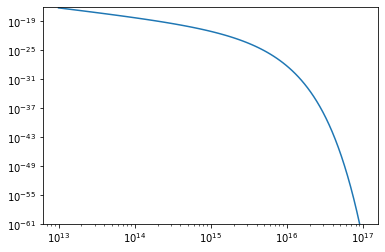

In [91]:
plt.plot(M, dndM)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-61, 1e-16)

In [92]:
print(1)

1
